In [1]:
import numpy as np
import pandas as pd
from chisq import EclipseFit
from etv_plots import nice_units, pretty_print, Plotter, ecl_time_to_etv, lsq_fit
from cbp_utils import im, g1, prec_timescale, crit_radius
import emcee
import corner
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 24, 'lines.linewidth': 2})

In [2]:
system = '5095'

# Best Fit

In [3]:
chain : np.ndarray = np.load('mcmc_out/' + system + '_chains_2.npy')
prob = np.load('mcmc_out/' + system + '_probs_2.npy')
ndim = chain.shape[-1]
good_walkers = -2*prob[:, -1] < 300
print('Good walkers: {}/{}'.format(np.sum(good_walkers), chain.shape[0]))
best_indx = prob.flatten()[np.nonzero(prob.flatten())].argmax()
print('Best chi-squared:', -2*prob.flatten()[best_indx])
x = chain.reshape(-1, ndim)[best_indx].copy()
x[14] *= 2
print('\nBest Fit')
print(pretty_print(x))
y = np.median(chain.reshape(-1, ndim), axis=0)
print('\nMedian')
print(pretty_print(y))

Good walkers: 100/100
Best chi-squared: 77.71158657741978

Best Fit

             P (d)    Epoch (d)   i (deg)        e    ω (deg)    Ω (deg)
Binary   18.610879     66.86186    84.747    0.502      109.2        0.0
Planet      239.52       95.605     88.02   0.0552     -46.27     -0.701

M_A (Msolar) 1.172
M_B (Msolar) 1.116
M_p (Mjup)   5.018
k2           0.0
    
γ (km/s)     4.67
γ (km/s)     78.01

Median

             P (d)    Epoch (d)   i (deg)        e    ω (deg)    Ω (deg)
Binary   18.610867     66.86171    84.463    0.496      109.1        0.0
Planet      239.51       95.714     86.49   0.0553     -46.21      -0.45

M_A (Msolar) 1.147
M_B (Msolar) 1.095
M_p (Mjup)   4.985
k2           0.0
    
γ (km/s)     4.642
γ (km/s)     77.44


In [4]:
fit = EclipseFit(system)
ecl_model, rv_model = fit.get_residuals(x, safe=False)
dbdt, b0 = fit.impact_regression(ecl_model)
print(b0, dbdt)

{'A': 1.214106413093936} {'A': 4.1343422840389967e-07}


In [5]:
print(f'chisq={fit.get_chisq(ecl_model, rv_model, ecl=True, rv=False, b=False):.2f} eclipses')
print(f'chisq={fit.get_chisq(ecl_model, rv_model, ecl=False, rv=True, b=False):.2f} RVs')
print(f'chisq={fit.get_chisq(ecl_model, rv_model, ecl=False, rv=False, b=True):.2f} impact parameter')
print(f'chisq={fit.get_chisq(ecl_model, rv_model, ecl=True, rv=True, b=True):.2f} total')
print((~(ecl_model['A']['data_t']).isna()).sum(), 'eclipses')
print(2*(~(rv_model['A']['rv']).isna()).sum(), 'RVs')

chisq=60.90 eclipses
chisq=16.65 RVs
chisq=0.16 impact parameter
chisq=77.71 total
67 eclipses
24 RVs


# Data

In [6]:
plot = Plotter(system)

Text(0.5, 0, 'Outer Orbital Phase')

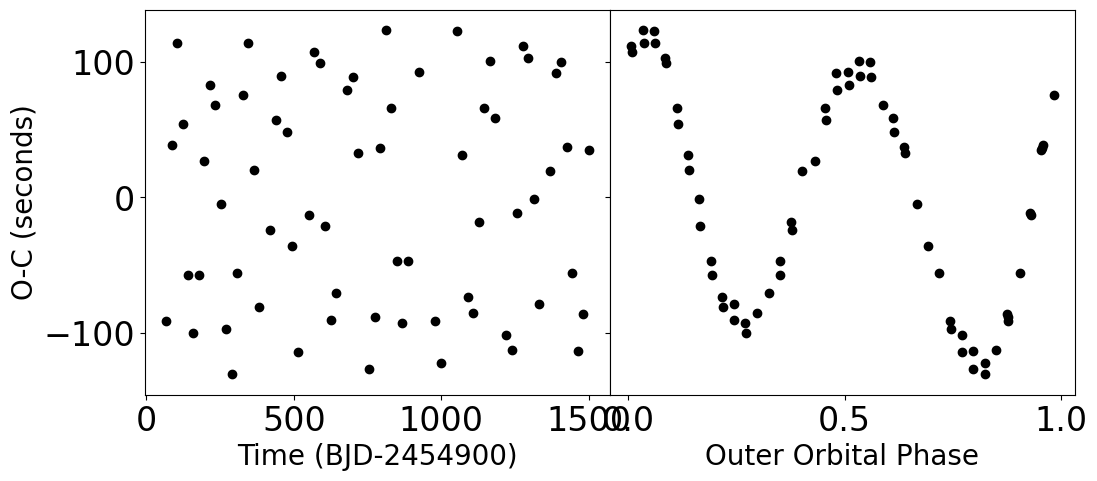

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(12,5), sharey=True, gridspec_kw={'wspace':0})
T0, P = lsq_fit(ecl_model['A']['data_t'])
axs[0].errorbar(ecl_model['A']['data_t'], 86400*ecl_time_to_etv(ecl_model['A']['data_t'], P, T0), 
            86400*ecl_model['A']['data_err'], linestyle='None', color='k', marker='o')
axs[0].set_xlabel('Time (BJD-2454900)', fontsize=20)
axs[0].set_ylabel('O-C (seconds)', fontsize=20)

axs[1].errorbar(plot.time_to_phase(ecl_model['A']['data_t'], x[6], 235.9), 
            86400*ecl_time_to_etv(ecl_model['A']['data_t'], P, T0), 
            86400*ecl_model['A']['data_err'], linestyle='None', color='k', marker='o')
axs[1].set_xlabel('Outer Orbital Phase', fontsize=20)
# plt.savefig(f'figures/etv_raw_{system}.pdf', dpi='figure')

In [8]:
if len(plot.ecl_stars) == 2:
    plot.etv_together(x, ecl_max=3000)

# Model Fit

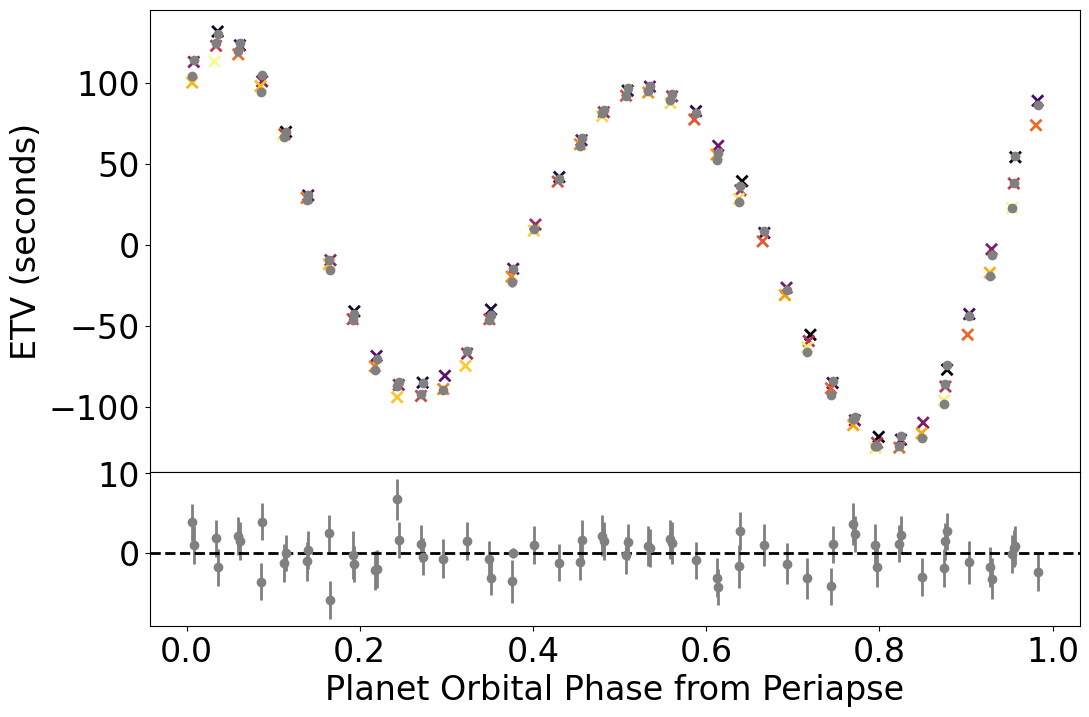

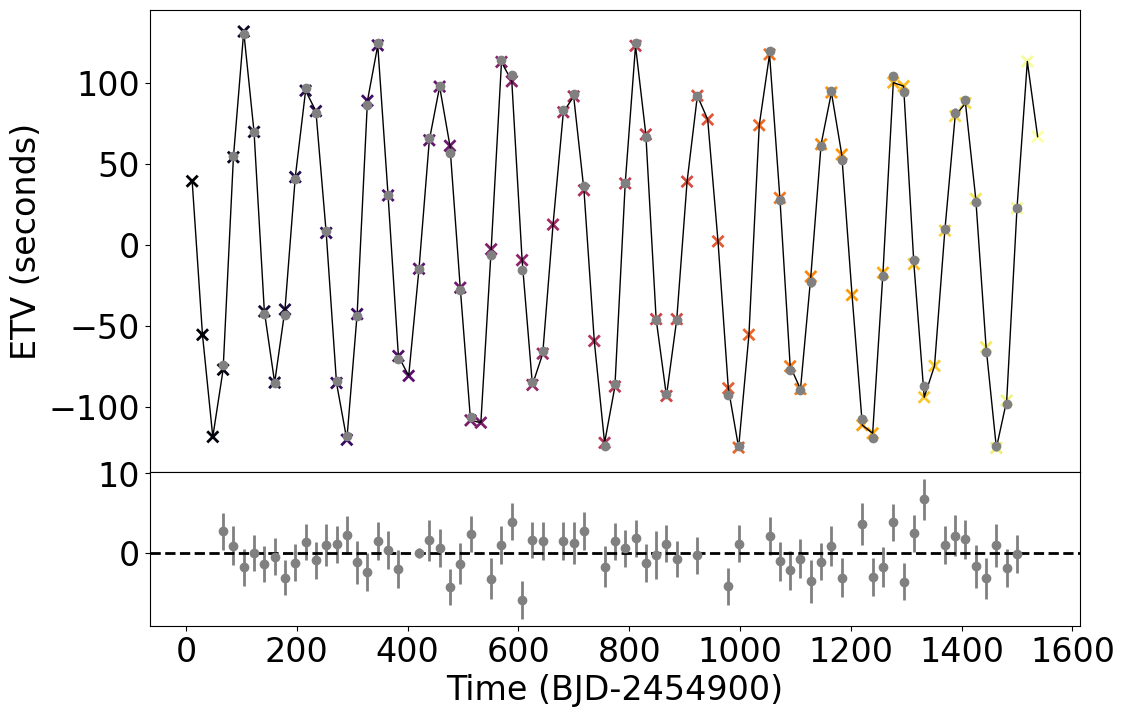

In [9]:
plot.etv_residuals(x, 'A', phased=True)
# plt.savefig(f'figures/etv_residuals_phased_{system}.pdf', dpi='figure')
plot.etv_residuals(x, 'A', phased=False, lines=True)
# plt.savefig(f'figures/etv_residuals_unphased_{system}.pdf', dpi='figure')
try:
    plot.etv_residuals(x, 'B', phased=True)
    plot.etv_residuals(x, 'B', phased=False)
except:
    pass

Data:   3.991e-07 t + 1.295
Model:  4.134e-07 t + 1.214


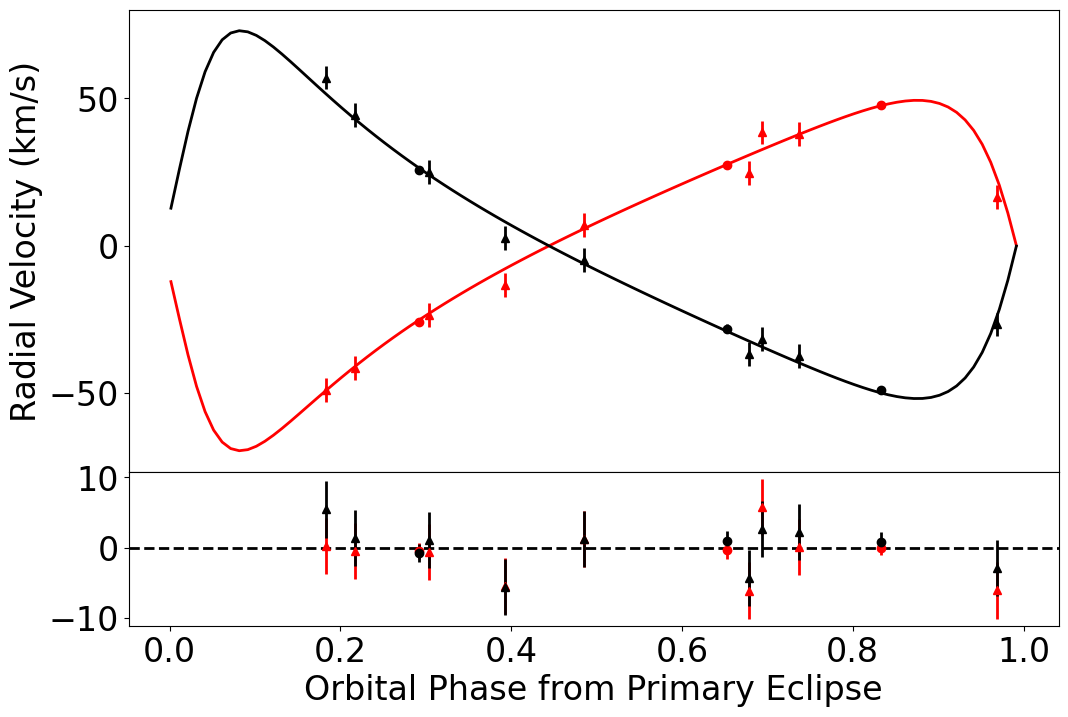

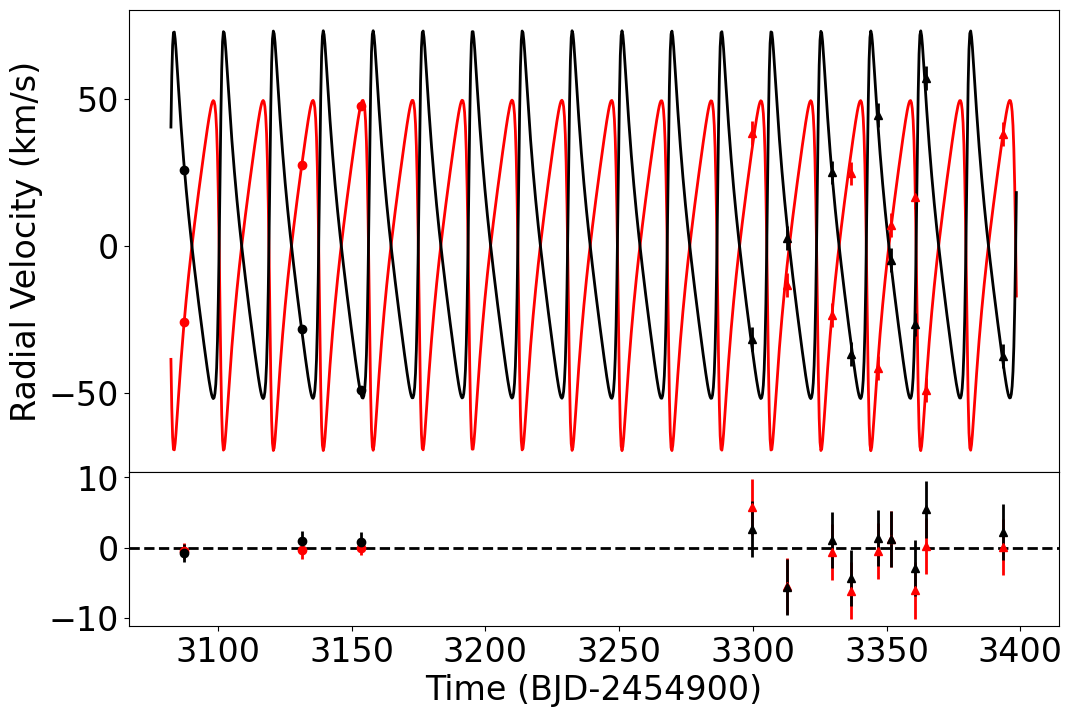

In [10]:
plot.rv_residuals(x, phased=True)
# plt.savefig(f'figures/rv_residuals_{system}.pdf', dpi='figure')
plot.rv_residuals(x, phased=False)
plot.impact_fit_quality(x)

# TESS Eclipses

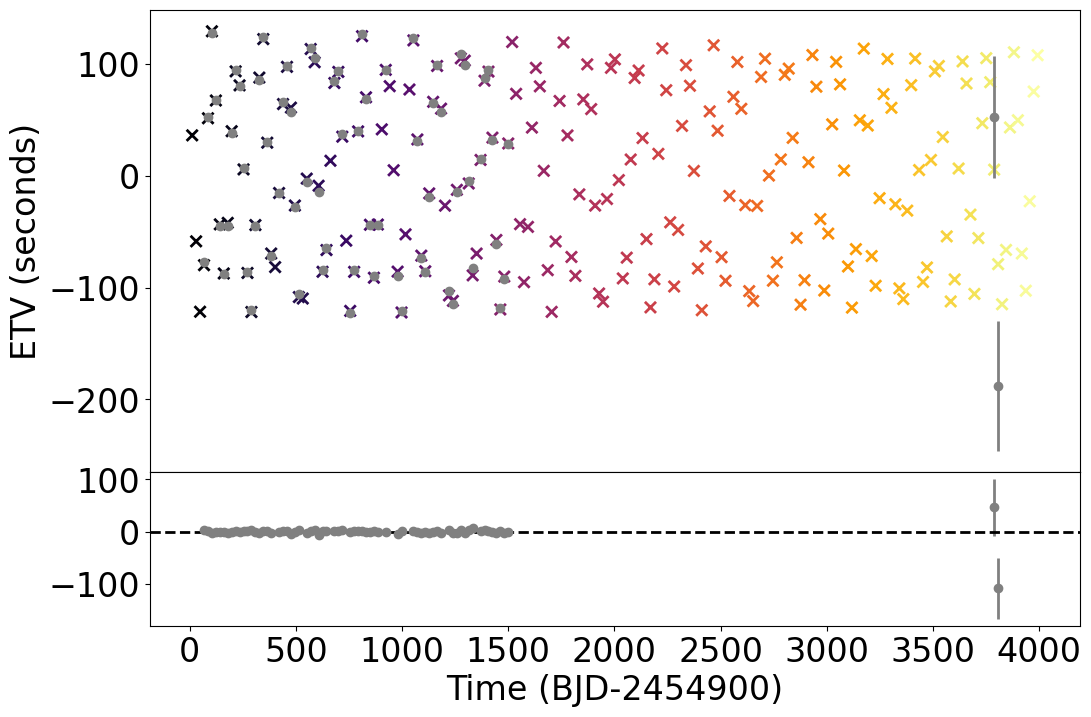

In [11]:
if system == '5095':
    plot_tess = Plotter(system)
    tess_points = pd.DataFrame([[3789.25839, 0.00063], 
                                [3807.86757, 0.00067]], 
                                index=[203, 204], columns=['data_t', 'data_err'])
    plot_tess.ecl_data['A'] = pd.concat((plot_tess.ecl_data['A'], tess_points))
    plot_tess.etv_residuals(x, 'A', phased=False, ecl_max=4000)
    # plt.savefig('figures/etv_residuals_unfolded_tess.pdf', dpi='figure')

# MCMC Diagnostics

Text(0.5, 0, 'Generation')

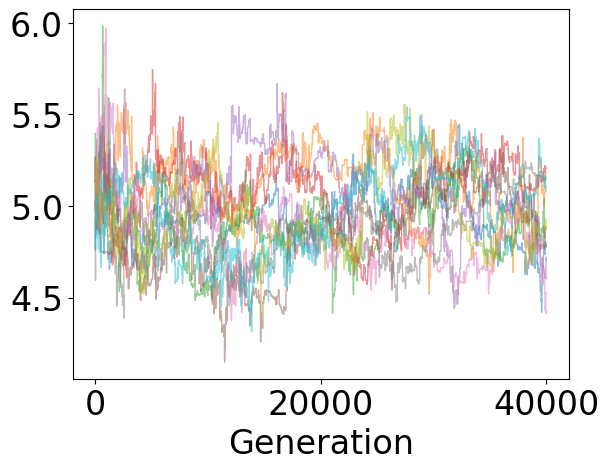

In [12]:
plt.plot(nice_units(chain)[:10,:,13].T, alpha=0.5, lw=1)
plt.xlabel('Generation')

(50, 200)

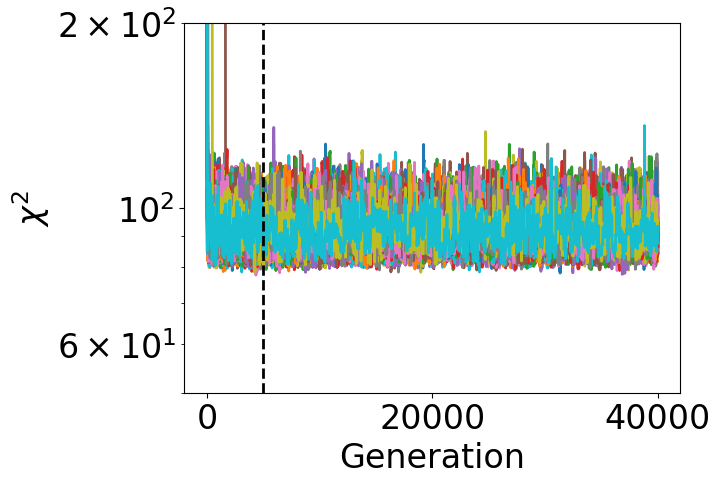

In [13]:
plt.plot(-2*prob.T)
plt.yscale('log')
plt.xlabel('Generation'); plt.ylabel('$\chi^2$')
plt.axvline(5000, color='k', linestyle='--')
plt.ylim(50, 200)

In [14]:
print(-2*prob[:,-1])

[ 99.52616021  89.3537147   92.50392985 101.49494125  95.41846686
  94.67333519  92.39693673  84.55373086  91.91503031  95.32448726
  95.87279558 105.17184875  88.38861464  89.07194485  88.10996697
  97.80655287  90.59444327  98.89461268  85.10124441  88.26312286
  93.68149294  91.74839111  86.51632732  99.24300299 109.00898664
  93.07788409 106.37576611  91.70359706  94.50441357  92.44371573
  91.53529074  84.46548929  90.24260043  89.89023542  86.99204696
 100.79076082  86.52188267  87.93100689 100.30693072 100.02280928
  89.82690489  94.70988416  91.1939965   86.12173593 114.11334795
  92.54190671  88.04351893  91.29784048  99.61309807  85.24581972
  94.55663337  93.29348673  93.87890703  90.40989617  92.45051168
  91.31695082  87.57434098  87.07692251  88.21467461  89.68550656
  89.3979406   96.07875239  93.55244694  84.25022117 101.10401905
  90.69602102  86.45418965  88.39704279  88.97084346  98.2105925
  84.46028486 100.02960833  84.77715287  91.11455064  85.68660064
  89.017366

In [15]:
dof = sum(map(len, plot.ecl_data.values())) + sum(map(len, plot.rv_data.values())) + 2 - 16
print('Reduced chi^2: {:.4f}'.format(-2*prob.flatten()[best_indx]/dof))

Reduced chi^2: 1.0092


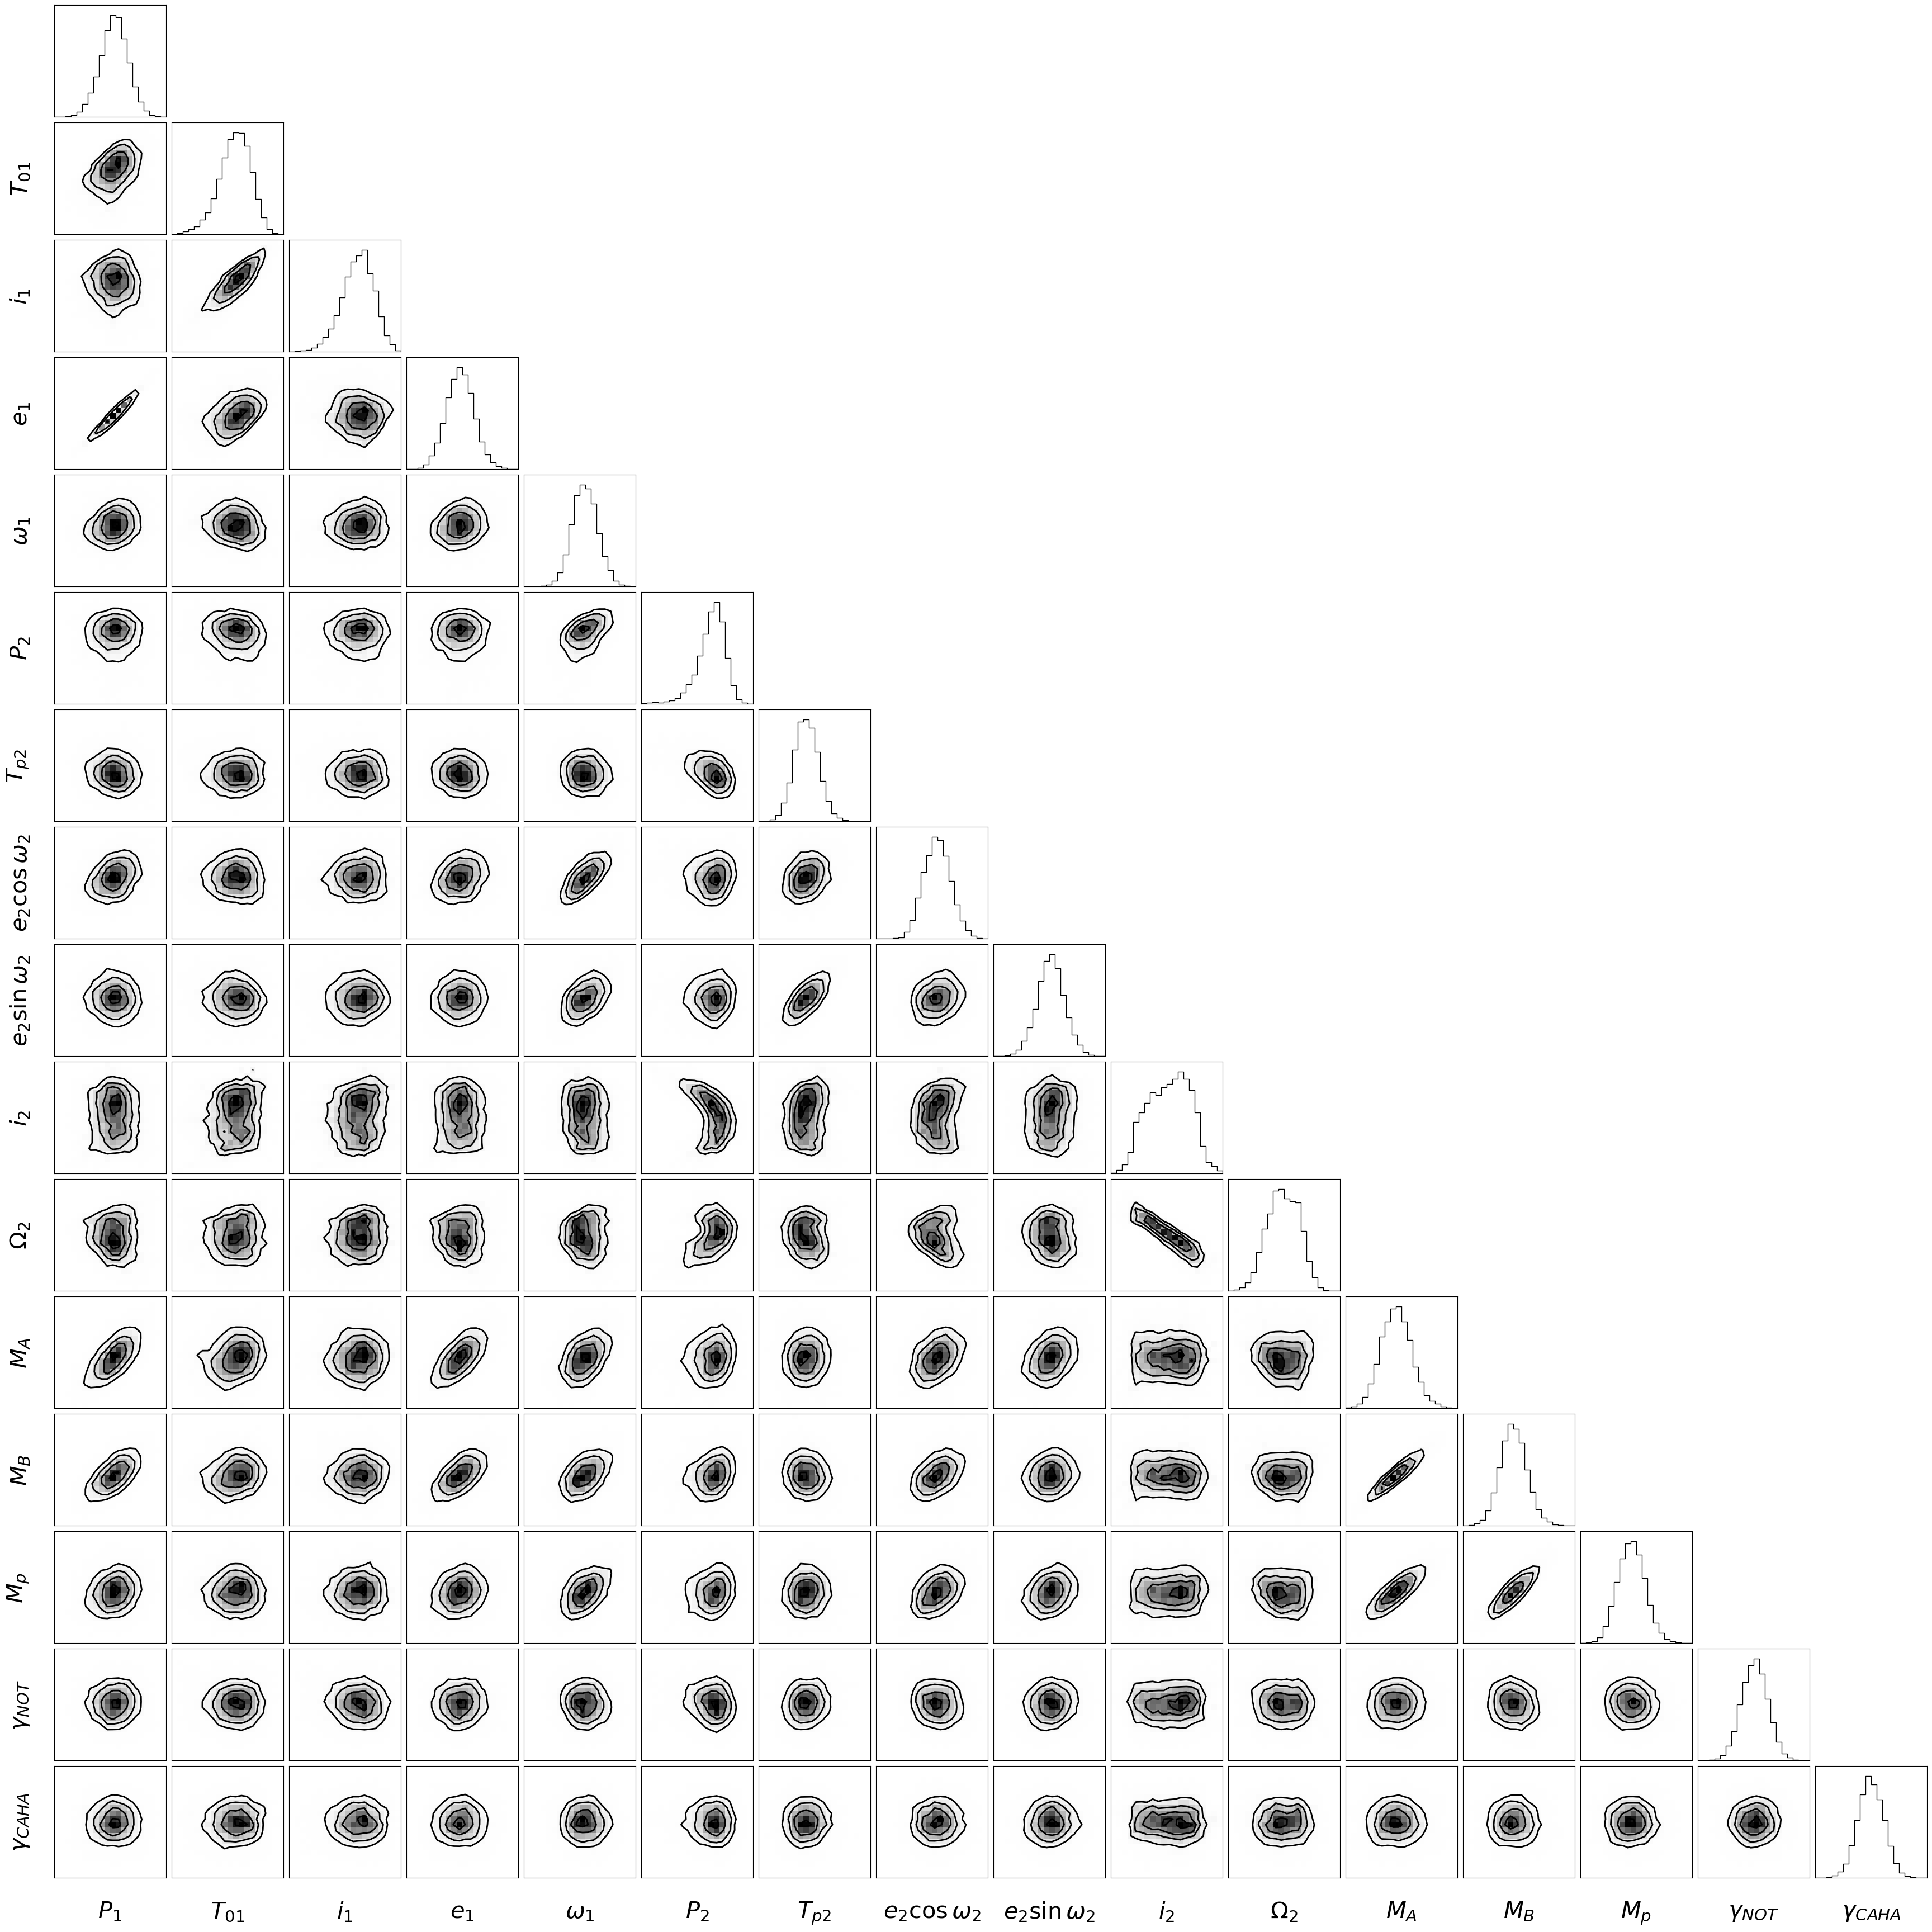

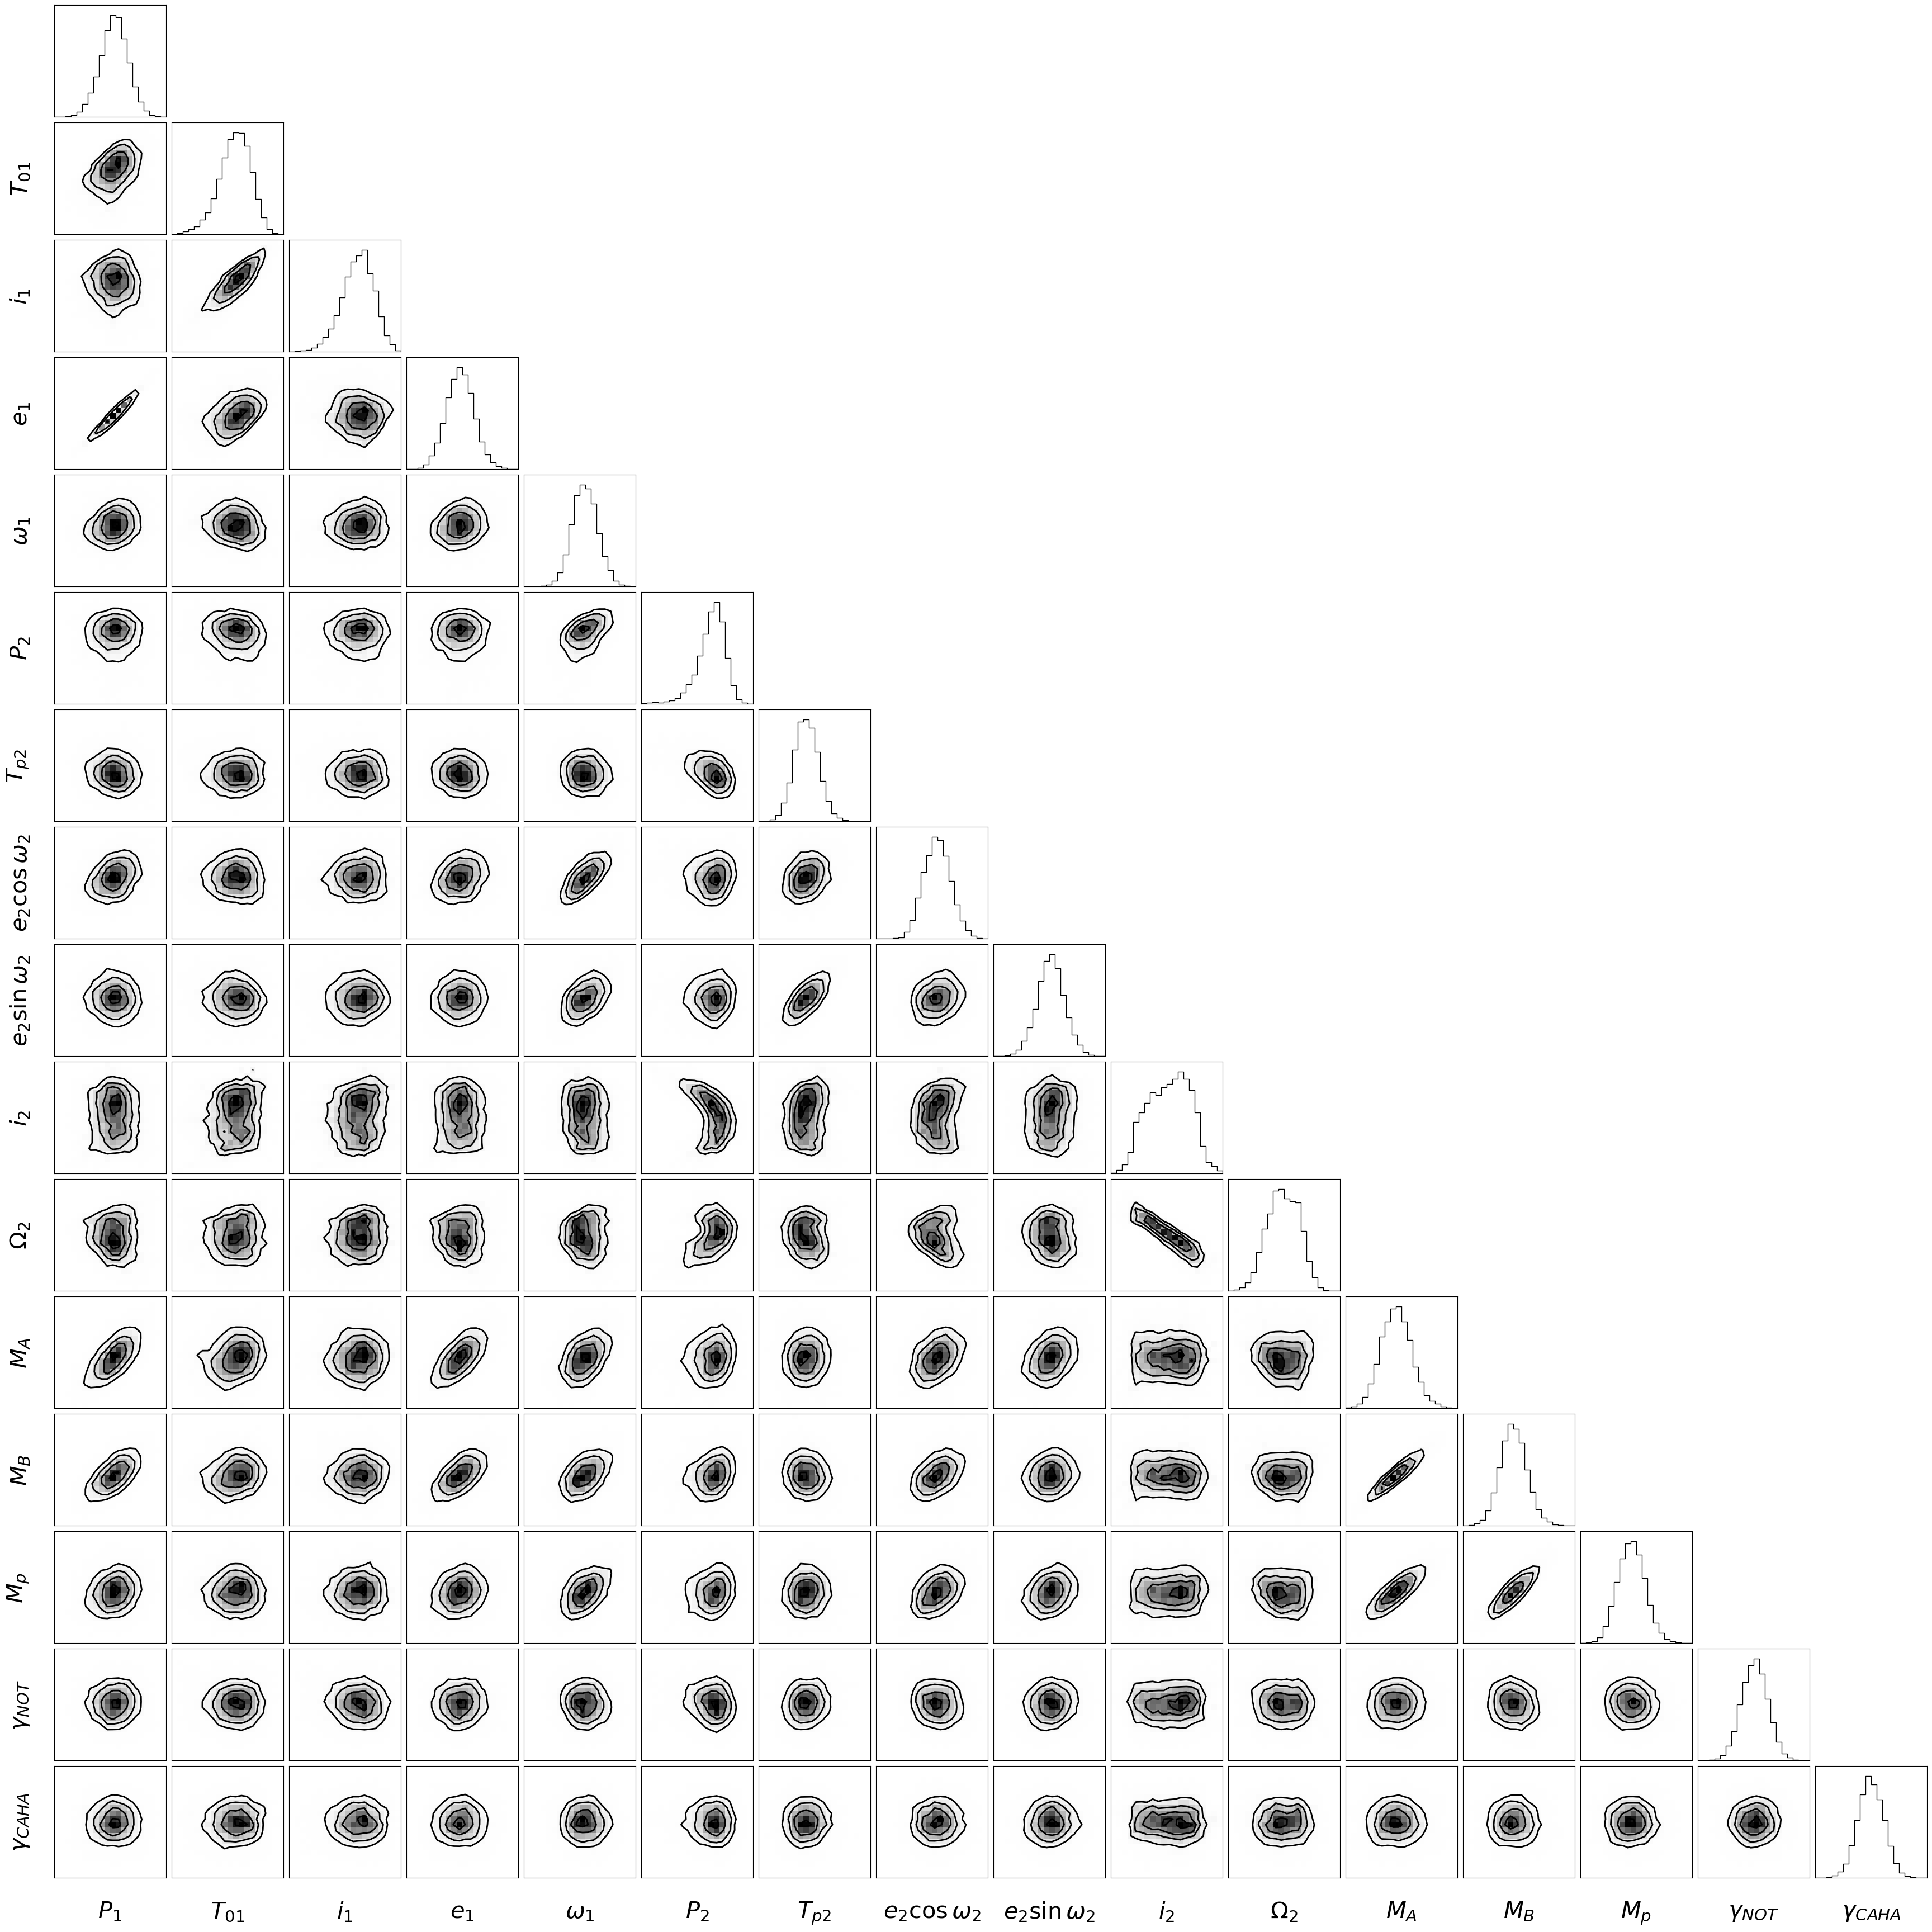

In [16]:
if system == '5095':
    labels = ['$P_1$', '$T_{01}$', '$i_1$', '$e_1$', '$\omega_1$',
              '$P_2$', '$T_{p2}$', '$e_2\cos\omega_2$', '$e_2\sin\omega_2$', '$i_2$', '$\Omega_2$',
              '$M_A$', '$M_B$', '$M_p$', '$\gamma_{NOT}$', '$\gamma_{CAHA}$']
corner.corner((nice_units(chain[:, 5000:, :].reshape(-1, 17)).T[chain.reshape(-1, 17).std(axis=0) > 1e-10]).T,
              labels=labels, plot_datapoints=False, max_n_ticks=0, labelpad=-0.1, label_kwargs={'fontsize':30})
# plt.savefig(f'figures/{system}_corner.pdf', dpi='figure')

# Derived system quantities

In [17]:
burn_chain = chain[:,5000:].reshape(-1, 17)
burn_prob = prob[:,5000:].reshape(-1)
G = 0.00029591220828559104
a_bin = (G*(burn_chain[...,11] + burn_chain[...,12])*burn_chain[...,0]/(4*np.pi**2))**(1/3)
a_p = (G*(burn_chain[...,11] + burn_chain[...,12])*burn_chain[...,5]/(4*np.pi**2))**(1/3)
if system == '5095':
    R_A = 1.45*0.00465
    R_B = 1.34*0.00465
    prim_ecl_constraint = (R_A + R_B)/a_bin * (1 + burn_chain[...,3]*np.sin(burn_chain[...,4])/(1 - burn_chain[...,3]**2)) > np.cos(burn_chain[...,2])
    sec_ecl_constraint =  (R_A + R_B)/a_bin * (1 - burn_chain[...,3]*np.sin(burn_chain[...,4])/(1 - burn_chain[...,3]**2)) < np.cos(burn_chain[...,2])
    print(np.sum(prim_ecl_constraint)/len(burn_chain[...,2]))
    print(np.sum(sec_ecl_constraint)/len(burn_chain[...,2]))
    burn_chain = burn_chain[prim_ecl_constraint & sec_ecl_constraint]
    burn_prob = burn_prob[prim_ecl_constraint & sec_ecl_constraint]

1.0
1.0


In [18]:
i_ms = {'Kepler-16b': [0.31, 'C1'], 
'Kepler-34b': [1.86, 'C2'], 'Kepler-35b': [1.07, 'C3'], 
'Kepler-38b': [0.18, 'C4'], 
'Kepler-47b': [0.27, 'C5'], 'Kepler-47c': [1.16, 'C5'], 'Kepler-47d': [1.38, 'C5'], 
'Kepler-64b': [2.81, 'C6'], 
'Kepler-413b': [4.07, 'C7'], 'Kepler-453b': [2.30, 'C8'], 'Kepler-1647b': [2.99, 'C9'], 
'Kepler-1661b': [0.93, 'C10'], 'PH-1b': [2.81, 'C11'], 'TOI-1338b': [0.98, 'C12']}

i_ms = pd.DataFrame(i_ms, index=['i_m', 'c']).T
i_ms['c'].values

array(['C1', 'C2', 'C3', 'C4', 'C5', 'C5', 'C5', 'C6', 'C7', 'C8', 'C9',
       'C10', 'C11', 'C12'], dtype=object)

95% upper limit of mutual inclination: 8.214 deg
Median mutual inclination: 3.715 deg
Best fit i_m: 3.345


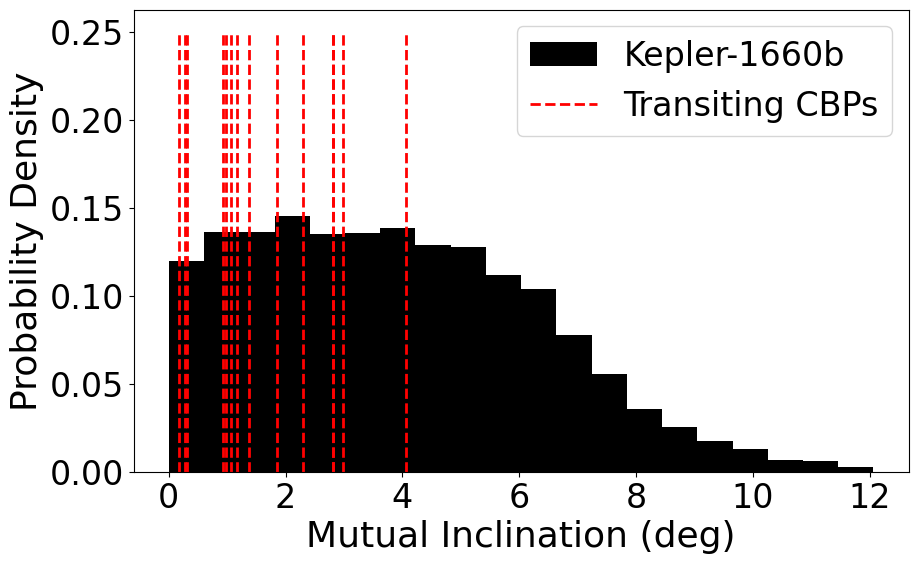

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.hist(np.degrees(im(burn_chain[...,2], burn_chain[...,9], burn_chain[...,10])), 
         bins=20, density=True, color='k', label='Kepler-1660b')
ax.set_xlabel('Mutual Inclination (deg)', fontsize=26)
ax.set_ylabel('Probability Density', fontsize=26)
ax.vlines(x=i_ms['i_m'], ymin=0, ymax=0.25, linestyles='dashed', linewidth=2, colors='red', label='Transiting CBPs')
plt.legend()
# plt.savefig(f'figures/im_constraint_{system}.pdf', dpi='figure', bbox_inches="tight")

i_m_95_upper = np.percentile(np.degrees(im(burn_chain[...,2], burn_chain[...,9], burn_chain[...,10])), 95)
print('95% upper limit of mutual inclination: {:.3f} deg'.format(i_m_95_upper))
print('Median mutual inclination: {:.3f} deg'.format(np.median(np.degrees(im(burn_chain[...,2], burn_chain[...,9], burn_chain[...,10])))))
i_m_chain = np.degrees(im(burn_chain[...,2], burn_chain[...,9], burn_chain[...,10]))
# print(np.abs(np.percentile(i_m_chain, 84.15) - np.percentile(i_m_chain, 50)))
# print(np.abs(np.percentile(i_m_chain, 15.85) - np.percentile(i_m_chain, 50)))
print('Best fit i_m: {:.3f}'.format(np.degrees(im(x[2], x[9], x[10]))))

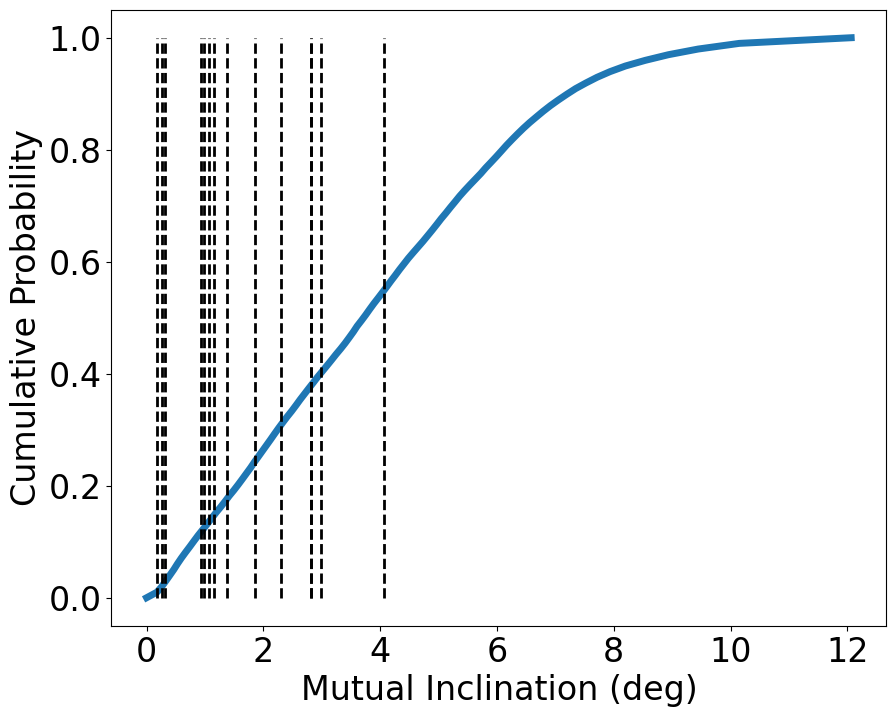

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))
ax.plot(np.quantile(np.degrees(im(burn_chain[...,2], burn_chain[...,9], burn_chain[...,10])), np.linspace(0, 1, 100)), np.linspace(0, 1, 100), lw=5)
ax.set_xlabel('Mutual Inclination (deg)', fontsize=24)
ax.set_ylabel('Cumulative Probability', fontsize=24)
ax.vlines(i_ms['i_m'], 0, 1, linestyles='dashed', linewidth=2, color='k')
# plt.savefig(f'figures/im_constraint_cdf_{system}.pdf', dpi='figure', bbox_inches="tight")

Text(0.5, 0, 'Dynamical Argument of Periastron')

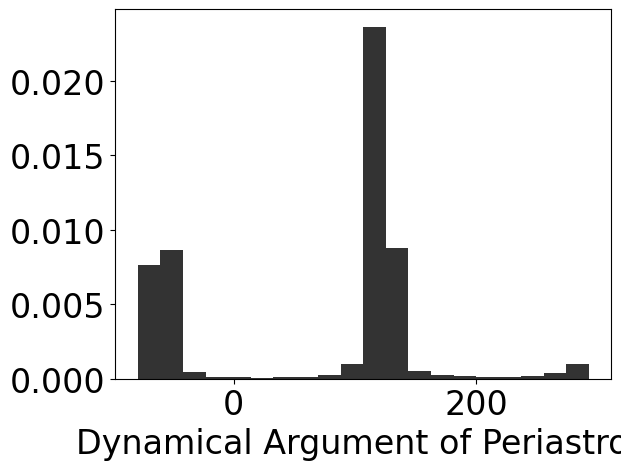

In [21]:
plt.hist(np.degrees(g1(burn_chain[...,2], burn_chain[...,9], burn_chain[...,10], burn_chain[...,4])), 
         bins=20, density=True, color='0.2')
plt.xlabel('Dynamical Argument of Periastron')

a_planet/a_c = 1.517 ± 0.015


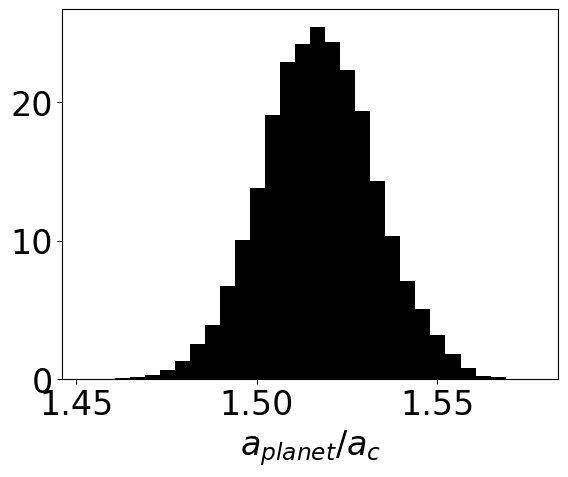

In [22]:
a_c = crit_radius(burn_chain[...,0], burn_chain[...,5], burn_chain[...,3], burn_chain[...,11], burn_chain[...,12])
plt.hist(a_c, bins=30, color='k', density=True);
plt.xlabel(r'$a_{planet}/a_c$')
print('a_planet/a_c = {:.3f} ± {:.3f}'.format(a_c.mean(), a_c.std()))

/home/max/Documents/Fabrycky/etv-fit/cbp_utils.py:38: RuntimeWarning: invalid value encountered in arcsin
  return np.where(k_sq_ < 1, ellipk(k_sq_), ellipkinc(np.arcsin(1/np.sqrt(k_sq_)), k_sq_))


T_prec = 86.162 ± 0.665


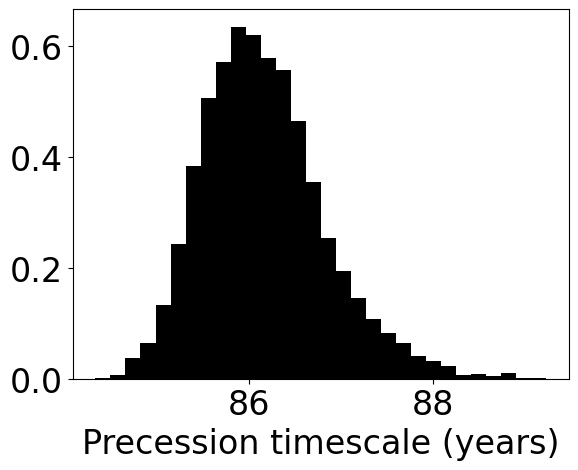

In [23]:
T_precs = prec_timescale(burn_chain[...,0], burn_chain[...,5], burn_chain[...,3], 
                         np.sqrt(burn_chain[...,7]**2 + burn_chain[...,8]**2), 
                         im(burn_chain[...,2], burn_chain[...,9], burn_chain[...,10]), 
                         g1(burn_chain[...,2], burn_chain[...,9], burn_chain[...,10], burn_chain[...,4]), 
                         burn_chain[...,11], burn_chain[...,12])
plt.hist(T_precs/365.25, bins=30, color='k', density=True)
plt.xlabel('Precession timescale (years)')
print('T_prec = {:.3f} ± {:.3f}'.format(T_precs.mean()/365.25, T_precs.std()/365.25))

In [24]:
# minimum mutual inclination to be guaranteed to transit
delta = R_A + R_B

mu_A = burn_chain[...,11]/(burn_chain[...,11] + burn_chain[...,12])
mu_B = burn_chain[...,12]/(burn_chain[...,11] + burn_chain[...,12])

i_m_lim_A = delta*(1/a_bin - mu_A*1/a_p) - R_A/a_p
i_m_lim_B = delta*(1/a_bin - mu_B*1/a_p) - R_B/a_p

print('Minimum i_m to transit A: {:.2f} deg'.format(np.degrees(i_m_lim_A.mean())))
print('Minimum i_m to transit B: {:.2f} deg'.format(np.degrees(i_m_lim_B.mean())))

# probability of transit

P_A = np.where(im(burn_chain[...,2], burn_chain[...,9], burn_chain[...,10]) > i_m_lim_A, 1, (im(burn_chain[...,2], burn_chain[...,9], burn_chain[...,10]) + R_A/a_p)/(delta*(1/a_bin - mu_B/a_p)))
P_B = np.where(im(burn_chain[...,2], burn_chain[...,9], burn_chain[...,10]) > i_m_lim_B, 1, (im(burn_chain[...,2], burn_chain[...,9], burn_chain[...,10]) + R_B/a_p)/(delta*(1/a_bin - mu_A/a_p)))

print('Probability of transiting A: {:.2f}%'.format(100*P_A.mean()))
print('Probability of transiting B: {:.2f}%'.format(100*P_B.mean()))

Minimum i_m to transit A: 6.13 deg
Minimum i_m to transit B: 6.42 deg
Probability of transiting A: 70.20%
Probability of transiting B: 69.07%


In [25]:
# Gaia
a_reflex = burn_chain[...,13]/(burn_chain[...,11] + burn_chain[...,12])**(2/3) * (G/(4*np.pi**2) * burn_chain[...,5]**2)**(1/3)
print('Reflex motion of binary: {:.5f} mas'.format(0.8216*a_reflex.mean()))

# Direct imaging
print('Separation of planet from binary: {:.4} mas'.format(0.8216*a_p.mean()))

Reflex motion of binary: 0.00172 mas
Separation of planet from binary: 0.1308 mas


1.0469086437886823 0.023637012189769074


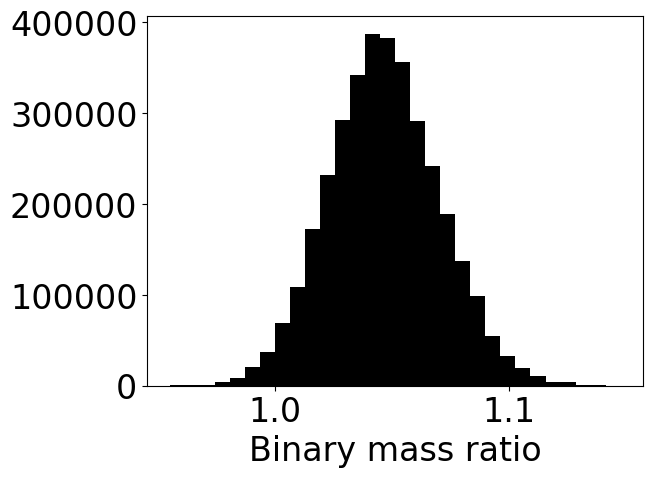

In [26]:
plt.hist(burn_chain[...,11]/burn_chain[...,12], bins=30, color='k')
plt.xlabel('Binary mass ratio');
mass_rat = burn_chain[...,11]/burn_chain[...,12]
print(mass_rat.mean(), mass_rat.std())

# Output for paper

In [27]:
flatchain = burn_chain
paper_chain = np.empty_like(flatchain)
paper_chain[...,:2] = flatchain[...,:2] # P_1 and T_01
paper_chain[...,2] = flatchain[...,3] # e_1
paper_chain[...,3] = np.degrees(flatchain[...,2]) # i_1
paper_chain[...,4] = np.degrees(flatchain[...,4]) # omega_1
paper_chain[...,5:7] = flatchain[...,5:7] # P_2 and T_p2
paper_chain[...,7] = np.sqrt(flatchain[...,7]**2 + flatchain[...,8]**2) # e_2
paper_chain[...,8] = np.degrees(flatchain[...,9]) # i_2
paper_chain[...,9] = np.degrees(np.arctan2(flatchain[...,8], flatchain[...,7])) # omega_2
paper_chain[...,10] = np.degrees(flatchain[...,10]) # Omega_2
paper_chain[...,11:13] = flatchain[...,11:13] # M_A and M_B
paper_chain[...,13] = 1047.58*flatchain[...,13] # M_p
paper_chain[...,14:] = flatchain[...,14:] # k_1, gamma(s)

best_indx_paper = burn_prob.argmax()

In [28]:
table = pd.DataFrame(index=['Orbital Period, $P_1$ (days)', 'Time of eclipse, $T_{01}$ (BJD-2454900)', 'Eccentricity, $e_1$', 'Inclination, $i_1$ (degrees)', 
                            'Argument of periapse, $\omega_1$ (degrees)', 'Orbital period, $P_2$ (days)', 'Time of periapse, $T_P$ (BJD-2454900)', 
                            'Eccentricity, $e_2$', 'Inclination, $i_2$', 'Argument of periapse, $\omega_2$ (degrees)', 'Longitude of ascending node, $\Omega_2$ (degrees)', 
                            'Primary star mass, $M_A$ $(M_\odot)$', 'Secondary star mass, $M_B$ $(M_\odot)$', 'Planet mass, $M_p$ $(M_J)$', 
                            'k_2', 'Barycentric radial velocity (NOT), $\gamma_1$ (km/s)', 'Barycentric radial velocity (CARMENES), $\gamma_2$ (km/s)'])

table['Maximum Likelihood Value'] = paper_chain[best_indx_paper]
table['Median'] = np.median(paper_chain, axis=0)
# table['Upper uncertainty'] = np.abs(np.percentile(paper_chain, 84.15, axis=0) - np.percentile(paper_chain, 50, axis=0))
# table['Lower uncertainty'] = np.abs(np.percentile(paper_chain, 15.85, axis=0) - np.percentile(paper_chain, 50, axis=0))
table['1\sigma uncertainty'] = paper_chain.std(axis=0)
print(table.style.to_latex(column_format='cccc',
    environment='deluxetable'))

\begin{deluxetable}
\begin{tabular}{cccc}
 & Maximum Likelihood Value & Median & 1\sigma uncertainty \\
Orbital Period, $P_1$ (days) & 18.610875 & 18.610869 & 0.000031 \\
Time of eclipse, $T_{01}$ (BJD-2454900) & 66.861873 & 66.861694 & 0.000302 \\
Eccentricity, $e_1$ & 0.503209 & 0.497295 & 0.017219 \\
Inclination, $i_1$ (degrees) & 84.669903 & 84.399370 & 0.765970 \\
Argument of periapse, $\omega_1$ (degrees) & 108.335136 & 109.094067 & 1.794210 \\
Orbital period, $P_2$ (days) & 239.479851 & 239.504422 & 0.068620 \\
Time of periapse, $T_P$ (BJD-2454900) & 95.810929 & 95.729701 & 0.815438 \\
Eccentricity, $e_2$ & 0.055109 & 0.055414 & 0.001469 \\
Inclination, $i_2$ & 80.165795 & 86.312450 & 4.211167 \\
Argument of periapse, $\omega_2$ (degrees) & -46.577560 & -46.173460 & 1.868484 \\
Longitude of ascending node, $\Omega_2$ (degrees) & 0.893848 & -0.437135 & 0.931327 \\
Primary star mass, $M_A$ $(M_\odot)$ & 1.136574 & 1.149992 & 0.072809 \\
Secondary star mass, $M_B$ $(M_\odot)$ & 1.0